In [2]:
from collections import Counter
import pickle as pkl
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset, SubsetRandomSampler

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [3]:
class Vec21Dataset(Dataset):
    def __init__(self, note_vec, chords):
        'Initialization'
        self.note_vec = note_vec
        self.chords = chords

    def __len__(self):
        'Get the total length of the dataset'
        return len(self.note_vec)
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.note_vec[index], self.chords[index]

In [4]:
class BaselineNN(nn.Module):
    def __init__(self, vec_size, vocab_size, hidden = 128):
        super(BaselineNN, self).__init__();
        self.fc = nn.Sequential(
            nn.Linear(vec_size, 2*hidden),
            nn.ReLU(),
            nn.Linear(hidden*2, hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, vocab_size))
        self.relu = nn.ReLU()
        
    def forward(self, note_vec):
        out = self.fc(note_vec)
        return out

In [39]:
bach = pkl.load(open('bach_org.pkl',"rb"))
bach = [np.array(x) for x in bach]
bach = np.vstack(bach)

# haydn = pkl.load(open('pickle_vector_lists/Haydn_reduce_vectors_ffnn_21enc.pkl',"rb"))
# haydn = [np.array(x) for x in haydn]
# haydn = np.vstack(haydn)

#data = np.vstack((bach,haydn))
data = bach

In [40]:
SEED = 0
VAL_SIZE = 0.2
TEST_SIZE = 0.2

In [41]:
note_vec, chords = data[:, :-1], data[:,-1]

In [42]:
note_vec = np.asarray(note_vec, dtype = np.float32)

In [43]:
vtoi = {x: idx for idx, x in enumerate(list(Counter(chords).keys()))}
itov = {idx: x for x, idx in vtoi.items()}
encoded_chords = [vtoi[ch] for ch in chords]

In [44]:
encoded_chords = np.asarray([vtoi[ch] for ch in chords], dtype = np.int_)

In [45]:
vec_size = note_vec.shape[1]
vocab_size = len(vtoi)

In [46]:
note_train, note_test, chord_train, chord_test \
    = train_test_split(note_vec, encoded_chords, test_size=TEST_SIZE, random_state=SEED)

note_train, note_val, chord_train, chord_val \
    = train_test_split(note_vec, encoded_chords, test_size= VAL_SIZE/ (1-TEST_SIZE), random_state=SEED)

In [47]:
train_dataset = Vec21Dataset(note_train, chord_train)
val_dataset = Vec21Dataset(note_val, chord_val)
test_dataset = Vec21Dataset(note_test, chord_test)

In [48]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size =  batch_size)
test_loader =  DataLoader(test_dataset, batch_size =  batch_size)

In [49]:
model = BaselineNN(vec_size, vocab_size)

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [51]:
epochs = 10
train_losses = []
val_losses = []
for epoch in range(1,epochs+1):
    total_loss = 0
    
    model.train()
    train_pgbar = tqdm(train_loader)
    for idx, (note, chord) in enumerate(train_pgbar):
        
        pred = model(note)
        loss = criterion(pred, chord.long())
        optimizer.zero_grad()
        
        if loss.item() != 0:
            loss.backward()
            optimizer.step()
        
#         s = "Epoch: {} Train Loss: {:.5f}".format(epoch, loss.item())
#         tqdm.write(s)
        train_pgbar.set_postfix({'Epoch': epoch, 'Train Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    print("Total Training Loss: %.2f" % total_loss)
    train_losses.append(total_loss/len(train_loader))
    total_loss = 0
    
    model.eval()
    val_pgbar = tqdm(val_loader)
    for idx, (note, chord) in enumerate(val_pgbar):

        pred = model(note)
        loss= criterion(pred, chord.long())
        
#         s = "Epoch: {} Val Loss: {:.5f}".format(epoch, loss.item())
#         tqdm.write(s)
        val_pgbar.set_postfix({'Epoch': epoch, 'Val Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    print("Total Validation Loss: %.2f" % total_loss)
    val_losses.append(total_loss/len(val_loader))


Total Training Loss: 747.62



Total Validation Loss: 134.75



Total Training Loss: 372.05



Total Validation Loss: 110.56



Total Training Loss: 320.75



Total Validation Loss: 101.44



Total Training Loss: 296.48



Total Validation Loss: 96.77



Total Training Loss: 281.78



Total Validation Loss: 94.10



Total Training Loss: 271.36



Total Validation Loss: 91.56



Total Training Loss: 264.43



Total Validation Loss: 90.72



Total Training Loss: 257.70



Total Validation Loss: 89.10



Total Training Loss: 253.38



Total Validation Loss: 89.07



Total Training Loss: 248.72



Total Validation Loss: 87.97


In [52]:
import matplotlib.pyplot as plt

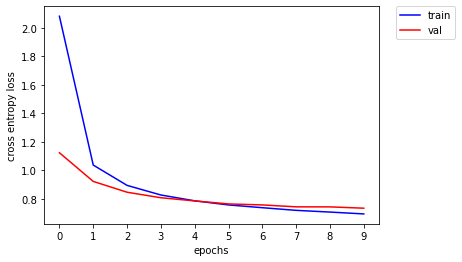

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(train_losses, color = "b", label = "train")
plt.plot(val_losses, color = "r", label = "val")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('epochs')
ax.set_ylabel('cross entropy loss') 
xint = range(len(train_losses))

plt.xticks(xint)
plt.show()

In [54]:
model.eval()
all_pred2 = []
all_label2 = []
for idx, (note, chord) in enumerate(tqdm(val_loader)):
        pred = model(note)
        pred = pred.detach().numpy().argmax(axis = 1)
        label = chord.detach().numpy()
        all_pred2.append(pred)
        all_label2.append(label)

In [55]:
all_pred2 = np.hstack(all_pred2)
all_label2 = np.hstack(all_label2)

In [56]:
np.sum(all_pred2 == all_label2)/len(all_pred2)

0.8061057723736681

In [57]:
decoded_chords = np.asarray([itov[ch] for ch in all_label2])
decoded_preds = np.asarray([itov[ch] for ch in all_pred2])

In [58]:
print(decoded_preds)
print(decoded_chords)

['B major' 'E major' 'C# minor' ... 'A dominant seventh'
 'Db minor seventh' 'E major']
['B major' 'E major' 'C# minor' ... 'A dominant seventh'
 'Fb minor major seventh' 'E major']


In [59]:
# EVALUATE CHORD FULL NAME AFTER DECODING
sum(1 for x,y in zip(decoded_preds, decoded_chords) if x == y) / len(decoded_chords)

0.8061057723736681

In [60]:
# SEPERATE EVALUATION OF ROOT AND QUALITY AFTER DECODING
# seperate all pred 
root_preds = []
quality_preds = []
for c in decoded_preds:
    sp = c.split(' ')
    root_preds.append(sp[0])
    quality_preds.append(' '.join(sp[1:]))

# seperate all lable 
root_labels = []
quality_labels = []
for c in decoded_chords:
    sp = c.split(' ')
    root_labels.append(sp[0])
    quality_labels.append(' '.join(sp[1:]))


In [61]:
# EVALUATE root AFTER DECODING
sum(1 for x,y in zip(root_preds, root_labels) if x == y) / len(root_labels)

0.8880172582859385

In [62]:
# EVALUATE quality AFTER DECODING
sum(1 for x,y in zip(quality_preds, quality_labels) if x == y) / len(quality_labels)

0.8225142184742106

In [33]:
co = Counter(chords)

In [34]:
most_common_chord = list(list(zip(*co.most_common(20)))[0])

In [35]:
for i in range(len(decoded_preds)):
    if decoded_preds[i] not in most_common_chord:
        decoded_preds[i] = "others"
    if decoded_chords[i] not in most_common_chord:
        decoded_chords[i] = "others"

In [36]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sn

In [37]:
cm = confusion_matrix(decoded_chords, decoded_preds, normalize = "true", labels = most_common_chord + ["others"])

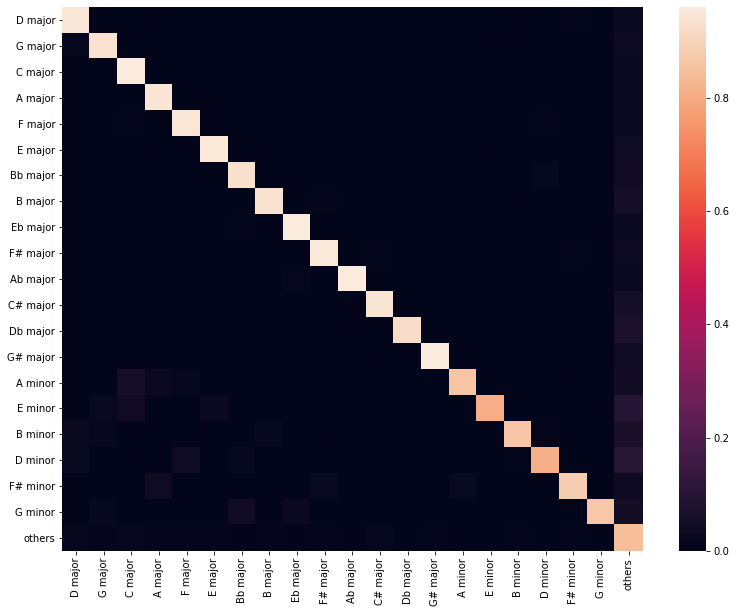

In [38]:
fig, ax = plt.subplots(figsize=(13,10)) 

sn.heatmap(cm, annot=False)
ax.set_xticklabels(most_common_chord + ["others"])
ax.set_yticklabels(most_common_chord + ["others"])
plt.yticks(rotation=0) 
plt.xticks(rotation="vertical") 
plt.show()
fig.savefig("confusion_bachhaydn_baseline.pdf", format = "pdf")

In [80]:
torch.save(model.state_dict(), "baseline_bach_and_haydn.pt")

In [46]:
symbol, num = list(zip(*co.most_common(50)))
symbol = list(symbol)
num = list(num)

In [49]:
symbol += ['others']
num += [np.sum(list(co.values())) - np.sum(num)]

In [51]:
num/=np.sum(num)

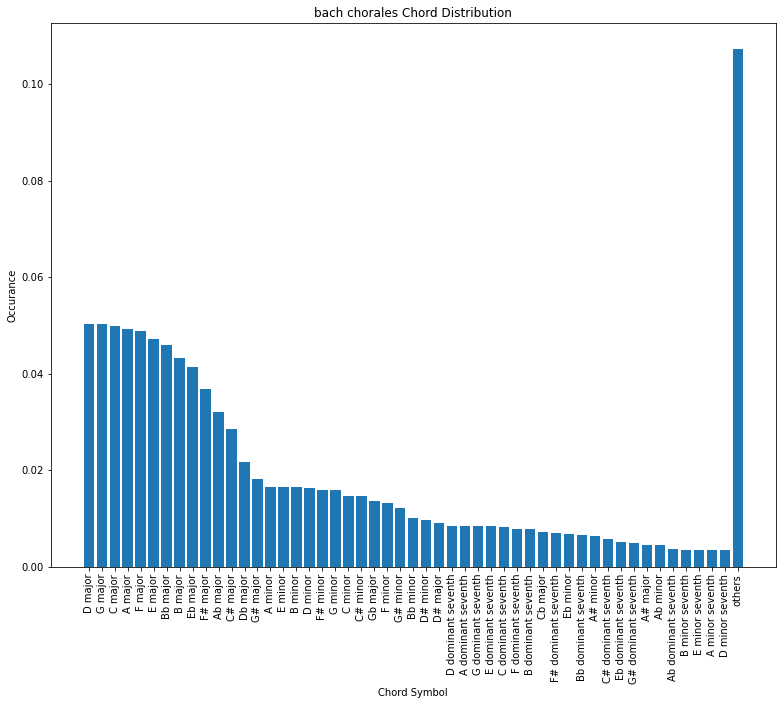

In [52]:
plt.subplots(figsize=(13,10)) 
x_pos = [i for i, _ in enumerate(symbol)]

plt.bar(x_pos, num)
plt.xlabel("Chord Symbol")
plt.ylabel("Occurance")
plt.title("bach chorales Chord Distribution")

plt.xticks(x_pos, symbol, rotation = "vertical")

plt.show()